### Steps

- 1) Assign each instance(ship) a prediction by max IOU 
        
        IOU : # of Common pixels / # of union of pixels
        
- 2) Calculate metric


### imports

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import sys
import shutil
import os
from pathlib import Path
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

In [2]:
sys.path.append("../fastai/")
from fastai.conv_learner import *

In [3]:
path = Path("../DATA/airbus-ship/")
files = list(path.iterdir())

In [13]:
list((path/'models').iterdir())

[PosixPath('../DATA/airbus-ship/models/resnet18_224.h5'),
 PosixPath('../DATA/airbus-ship/models/seg_resnet18_256.h5')]

### dummy test 

In [15]:
os.makedirs(path/"test_dummy", exist_ok=True)

In [22]:
dummy_test_files = np.random.choice(list((path/"test_all").iterdir()), size=10, replace=False)

In [23]:
for f in dummy_test_files: shutil.copyfile(f, path/"test_dummy"/f.name)

### step 1 - classifier 

#### make predictions

In [24]:
train_all_labels = pd.read_csv(path/"classification/train_all_lbs.csv")
test_all_labels = pd.read_csv(path/"classification/test_all_lbs.csv")

In [25]:
_, val_idx = train_test_split(train_all_labels, test_size=0.1, stratify=train_all_labels.has_ship, random_state=42)
val_idx = (val_idx.index).tolist()

In [26]:
arch = resnet18
sz = 224

In [27]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.1)

In [28]:
# cv_idxs automatically creates validation set
data = ImageClassifierData.from_csv(path, folder='train_all', bs=128, val_idxs=val_idx,
                                    csv_fname=path/'classification/train_all_lbs.csv', tfms=tfms, test_name="test_dummy")

In [29]:
learn = ConvLearner.pretrained(arch, data, precompute=False)

In [30]:
learn.load("resnet18_224")

In [42]:
preds, _ = learn.TTA(n_aug=4, is_test=True)

In [43]:
preds_mean = np.mean(preds, axis=0)

In [44]:
preds_mean_proba = np.exp(preds_mean)

In [45]:
preds_mean_labels = np.argmax(preds_mean_proba, axis=1)

In [47]:
preds_mean_proba, preds_mean_labels

(array([[0.99653, 0.00338],
        [0.97969, 0.01516],
        [0.99686, 0.00207],
        [0.99385, 0.00412],
        [0.56183, 0.41159],
        [0.96637, 0.02385],
        [0.9987 , 0.00081],
        [0.97108, 0.02552],
        [0.99742, 0.00255],
        [0.98839, 0.01057]], dtype=float32),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

#### get classification score

In [54]:
test_fnames = [fname.split("/")[1] for fname in data.test_ds.fnames]

In [55]:
test_fnames

['17cb21e97.jpg',
 '4e7d4b4aa.jpg',
 '792da8d7b.jpg',
 '32249e60a.jpg',
 'f6249943c.jpg',
 '7808e16ea.jpg',
 'b7443ca1c.jpg',
 '91c9a56f3.jpg',
 '85c280598.jpg',
 '7b293accf.jpg']

In [58]:
test_label_dict = dict(zip(test_all_labels.ImageId, test_all_labels.has_ship))

In [72]:
test_labels = A([test_label_dict[fname] for fname in test_fnames])

In [73]:
test_labels

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])

In [74]:
test_acc = np.mean(preds_mean_labels == test_labels)

In [75]:
print(f"classification accuracy : {np.round(test_acc, 3)}")

classification accuracy : 0.9


In [84]:
neg_preds = np.array(test_fnames)[preds_mean_labels == 0]
pos_preds = np.array(test_fnames)[preds_mean_labels == 1]

In [85]:
print(f"number of ships predicted as positive : {len(pos_preds)}")
print(f"number of ships predicted as negative : {len(neg_preds)}")

number of ships predicted as positive : 0
number of ships predicted as negative : 10


In [86]:
# acc of preds that were predicted as has no ship, aka : NPV (Negative predictive value)
predicted_negative = preds_mean_labels[preds_mean_labels == 0] 
predicted_negative_labels = test_labels[preds_mean_labels == 0] 

In [87]:
NPV = np.mean(predicted_negative == predicted_negative_labels)
print(f"NPV: {NPV}")

NPV: 0.9


### step 2 - load segmentation model

#### make predictions for has ship predicted

In [88]:
from fastai.models.unet import *
from fastai.dataset import *
from fastai.core import *

In [89]:
train_seg_lbs = pd.read_csv(path/"segmentations/train_seg_lbs.csv")

In [90]:
unique_img_ids = train_seg_lbs.ImageId.unique()
trn_fnames, val_fnames = train_test_split(unique_img_ids, test_size=0.1, random_state=42)

In [154]:
TRN_X = A([f"train_all/{fname}" for fname in trn_fnames])
TRN_Y = A([f"segmentations/train_masks/{fname}" for fname in trn_fnames])

VAL_X = A([f"train_all/{fname}" for fname in val_fnames])
VAL_Y = A([f"segmentations/train_masks/{fname}" for fname in val_fnames])

# FORCE POS_PRED
pos_preds =[neg_preds[4]] 
TEST_X = A([f"test_all/{fname}" for fname in pos_preds])

In [155]:
sz = 256

class FilesEncodedDataset(BaseDataset):
    def __init__(self, fnames, fnames2, transform, path):
        self.fnames = fnames
        self.fnames2 = fnames2
        self.path = path
        super().__init__(transform)
    
    def get_sz(self): return self.transform.sz
    def get_x(self, i): return open_image(os.path.join(self.path, self.fnames[i]))
    def get_y(self, i): 
        mask = cv2.imread(os.path.join(self.path, self.fnames2[i]), cv2.IMREAD_GRAYSCALE)
        mask = (mask - 30)/185
        return cv2.resize(mask, (sz, sz)).astype('float32')
        
    def get_n(self): return len(self.fnames)
    def get_c(self): return 0

    def resize_imgs(self, targ, new_path):
        dest = resize_imgs(self.fnames, targ, self.path, new_path)
        return self.__class__(self.fnames, self.y, self.transform, dest)

    def denorm(self,arr):
        """Reverse the normalization done to a batch of images.

        Arguments:
            arr: of shape/size (N,3,sz,sz)
        """
        if type(arr) is not np.ndarray: arr = to_np(arr)
        if len(arr.shape)==3: arr = arr[None]
        return self.transform.denorm(np.rollaxis(arr,1,4))

In [156]:
f = resnet18
tfms = tfms_from_model(f, sz, crop_type=CropType.NO, tfm_y=None) # imagenet stats

In [171]:
dataset = ImageData.get_ds(FilesEncodedDataset, trn=(TRN_X, TRN_Y),
                           val=(VAL_X, VAL_Y),
                           tfms=tfms, test=(TEST_X, TEST_X) , path = path)

In [172]:
# trn_dl, aug_dl, test_aug_dl
tfms[0]

[<fastai.transforms.Scale object at 0x7f7f226d1ac8>, <fastai.transforms.NoCrop object at 0x7f7f226d1be0>, <fastai.transforms.Normalize object at 0x7f7f226d1dd8>, <fastai.transforms.ChannelOrder object at 0x7f7f226d1cf8>]

In [173]:
# val_dl, fix_dl, test_dl
tfms[1]

[<fastai.transforms.Scale object at 0x7f7f226d1828>, <fastai.transforms.NoCrop object at 0x7f7f226d1f60>, <fastai.transforms.Normalize object at 0x7f7f226d1dd8>, <fastai.transforms.ChannelOrder object at 0x7f7f226d1ef0>]

In [174]:
data = ImageData(path, dataset, bs=16, num_workers=16, classes=None)

In [175]:
# load defined model# load  
def get_encoder(f, cut):
    base_model = (cut_model(f(True), cut))
    return nn.Sequential(*base_model)

def get_model(sz=128):
    """gets dynamic unet model"""
    # choose encoder
    f = resnet18
    cut, cut_lr = model_meta[f]
    cut, cut_lr

    # define encoder
    encoder = get_encoder(f, cut)

    # init model
    m = DynamicUnet(encoder, n_classes=1) # binary: ship - not ship

    # init upsample on cpu
    inp = torch.ones(1, 3, sz, sz)
    out = m(V(inp).cpu())

    # put model to gpu if exists
    if torch.cuda.device_count() != 0:
        m = m.cuda(0)
    return m

In [176]:
class BCELoss2D(nn.Module):
    def __init__(self):
        super(BCELoss2D, self).__init__()
        
    def forward(self, logits, targets):
        logits = logits.squeeze(1)
        return F.binary_cross_entropy_with_logits(logits, targets)

In [177]:
class UpsampleModel():
    def __init__(self, model, cut_lr, name='upsample'):
        self.model,self.name, self.cut_lr = model, name, cut_lr

    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.encoder), [self.cut_lr]))
        return lgs + [children(self.model)[1:]]

In [178]:
cut, cut_lr = model_meta[f]

In [179]:
model = get_model(sz=256)
models = UpsampleModel(model, cut_lr)

In [180]:
learn = ConvLearner(data, models)
learn.opt_fn=optim.Adam
learn.crit = BCELoss2D()

In [181]:
learn.load("seg_resnet18_256")

In [182]:
seg_preds = learn.predict(is_test=True)

In [183]:
seg_preds.shape

(1, 1, 256, 256)

In [184]:
seg_preds_labels = ((seg_preds > 0)*1).squeeze(1)

#### plot predictions

In [187]:
from seg_plots import show_imgmasks

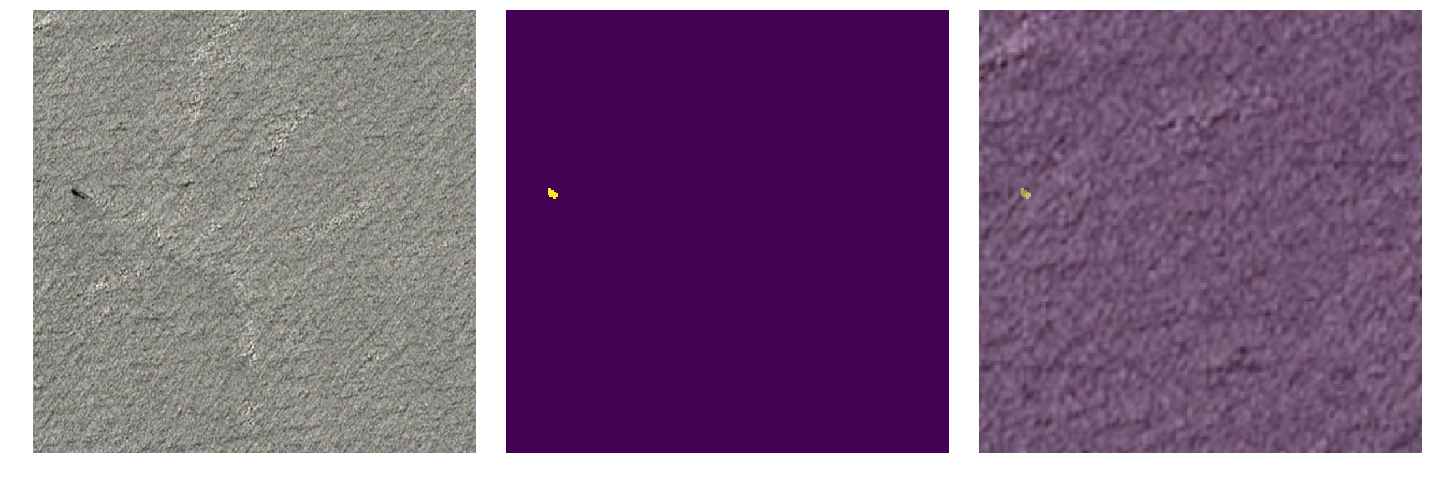

In [189]:
for i, (fname, mask_pred) in enumerate(zip(TEST_X, seg_preds_labels)):
    img = open_image(path/fname)
    show_imgmasks(img, mask_pred, (20, 20))

#### get segmentation score

In [242]:
from eval_metric import single_image_score

In [243]:
test_seg_lbs = pd.read_csv(path/"segmentations/test_seg_lbs.csv")

In [244]:
for i, (pred_i, fname) in enumerate(zip(seg_preds_labels, TEST_X)):    
    labels = label(pred_i)
    gt_rles = A(test_seg_lbs[test_seg_lbs.ImageId == fname.split("/")[-1]]["EncodedPixels"])
    score = single_image_score(labels, gt_rles)


        IOU matrix
        [0.40211]
        


In [238]:
score

0.0

### step 3 - calculate final score by hand

In [246]:
n_pos_preds = len(pos_preds)
n_neg_preds = len(neg_preds)

In [251]:
(n_neg_preds*score + n_neg_preds*NPV)/(n_neg_preds + n_pos_preds)

0.8181818181818182